# 混同行列(正誤分布のクロス表)，Accuracy，Precision，Recall，F値，macro平均，micro平均，重みつき平均といった評価尺度を理解する(2022/02/15)
---

## 概要
---
分類モデルを評価する指標について調べ，Pythonでシミュレーションを行う．

具体的に扱う項目は以下の通り．

- 混同行列(confusion matrix)
- 正解率(accuracy)
- 適合率(precision)
- 再現率(recall)
- F値(F1-score)
- macro平均
- micro平均
- 重みつき平均

macro平均以下の指標は，多分類モデルを評価するものである．つまり，データの分けられる種類が3種類以上のものに適用される評価指標である．

## 二値分類モデルの評価指標
---

二値分類モデルとは，データを2つにわける分類モデルのことである．検出したい物事が含まれるデータを「陽性」とし，それ以外のデータを「陰性」と表現することが多い．新型コロナウイルス感染症が蔓延している昨今の情勢では，比較的耳にする表現になっていると思う．

本節では，この二値分類モデルを評価する指標について述べる．並行して，Pythonを用いたシミュレーションを行う．分類モデルはSVM，データセットはBrest Cancer Wisconsinを用いる．

### 混同行列(Confusion Matrix)

混同行列は，以下の4つの要素を行列の形式で表現したものである．

- 真陽性(True Positive; TP)：分類器が陽性だと判定し，かつ実際に陽性であったデータの数
- 偽陽性(False Positive; FP)：分類器が陽性だと判定したが，実際には陰性であったデータの数
- 真陰性(True Negative; TN)：分類器が陰性だと判定し，かつ実際に陰性であったデータの数
- 偽陰性(False Nagetive; FN)：分類器が陰性だと判定したが，実際には陽性であったデータの数

それぞれの要素をヒートマップ形式で一覧することで，分類器の持つ性能や性質が分かる．例えば，真陽性と偽陽性がともに高い分類器については，陽性判定をする敷居が低い分類器だと捉えられる．つまり「どっちか迷ったら，とりあえず陽性判定をする」分類器だと解釈できる．

では実際に，混同行列を作成してみる．

In [1]:
# Brest Cancer Wisconsinデータセットを読み込む
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [2]:
# 前処理をする
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.loc[:,2:].values
y = df.loc[:,1].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [3]:
# SVMモデルの構築
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=1))])

In [4]:
# テストデータから混同行列を作る
from sklearn.metrics import confusion_matrix

y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_test, y_pred)
confmat

array([[71,  1],
       [ 2, 40]])

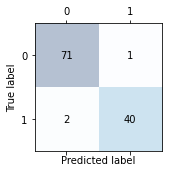

In [5]:
# 混同行列を見やすくするために，ヒートマップで表現する
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

今回のデータセットでは，悪性腫瘍(Malignant; M)を陽性(1)とみなし，良性腫瘍(Benign; B)を陰性(0)とみなしている．

ヒートマップを見ると，実際には悪性腫瘍であるのに良性だと誤分類しているケースが2件あり，実際には良性腫瘍であるのに悪性だと誤分類しているケースが1件あることが分かる．概ね分類はうまくいっているようだ．

### 正解率(Accuracy; ACC)

正解率は分類器にとって代表的な評価指標のうちの一つであり，もっともイメージしやすいものであろう．

式で表現すると，以下のようになる：

\begin{eqnarray}
ACC = \frac{TP+TN}{TP+TN+FP+FN}
\end{eqnarray}

つまり，すべてのケースの中で，分類器が正しく分類を行った割合を表している．

また，正解率の裏を返せば，誤分類率(Error Rate)を計算することも可能だ．

\begin{eqnarray}
ERR = \frac{FP+FN}{TP+TN+FP+FN} = 1 - ACC
\end{eqnarray}

混同行列の値などから直接算出しても問題はないが，scikit-learnを用いる場合には，分類器のクラスメソッドに「score」という名前で正解率を算出するものが定義されている．

In [6]:
# SVMの正解率
print('Accuracy of SVM model:', pipe_svc.score(X_test, y_test))

Accuracy of SVM model: 0.9736842105263158


### 適合率(Precision; PRE)
適合率も二値分類モデルを評価するための指標の一つである．定義は以下のように与えられる．

\begin{eqnarray}
PRE = \frac{TP}{TP + FP}
\end{eqnarray}

この指標は，分類器が陽性判定したデータのうち実際に陽性であったデータの割合を示している．1に近いほど良いモデルだと通常は判断することができる．

ただし，適合率が高いことが必ずしも分類器の性能の良さを表すわけではない場合がある．例えば極端な例として，ある分類器が最も自信のある陽性データ1つにのみ「陽性」という判定をした場合はどうだろうか．確かに適合率は1になるが，仮に他の陽性データがあれば，それらは全て見逃していることになる．

適合率の算出には，scikit-learnに専用の関数が用意されている．

In [7]:
# SVMの適合率
from sklearn.metrics import precision_score
print('Precision of SVM model:', precision_score(y_test, y_pred))

Precision of SVM model: 0.975609756097561


### 再現率(Recall; REC)
再現率も二値分類モデルを評価する指標の一つである．定義は以下のように与えられる．

\begin{eqnarray}
REC = \frac{TP}{P} = \frac{TP}{TP + FN}
\end{eqnarray}

これは，陽性データのうち分類器が「陽性」だと検出できたデータの割合を示している．この値も1に近いほど，一般的には良い分類モデルだと言うことができる．

ただし，こちらも適合率と同様に例外が存在する．極端な例として，すべてのデータを「陽性」だと判定する分類モデルを考える．$FN=0$であるから，再現率も1をとる．しかし，当然ながらこれは分類器として機能していない．

再現率の算出には，scikit-learnに専用の関数が用意されている．

In [8]:
# SVMの再現率
from sklearn.metrics import recall_score
print('Recall of SVM model:', recall_score(y_test, y_pred))

Recall of SVM model: 0.9523809523809523


### F値(F1-score)
適合率と再現率を見ると，これら2つの指標はトレードオフの関係にあることが分かる．つまり，「少しでも陽性判定のミスをなくそう」として適合率を上げると，本来陽性であったはずのデータがいくつか見逃され，再現率が下がる．逆に，「陽性データの見逃しを防ごう」として再現率を上げると，陽性ではないデータまで陽性判定される確率が上がり，適合率が下がる．

分類器の性能指標として，適合率・再現率の片方だけを重視するわけにはいかない．これを解決する指標の一つとして，F値が挙げられる．定義を以下に記す．

\begin{eqnarray}
F1 = 2 \times \frac{PRE \times REC}{PRE + REC}
\end{eqnarray}

これは適合率と再現率の調和平均をとった値になっていて，0から1までの値をとる．

F値の算出には，scikit-learnに専用の関数が用意されている．

In [9]:
# SVMのF値
from sklearn.metrics import f1_score
print('F1 score of SVM model:', f1_score(y_test, y_pred))

F1 score of SVM model: 0.963855421686747


## 多クラス分類モデルの評価指標
---
ここまで紹介してきた指標は，二値分類モデルの評価指標である．多クラス分類を行うモデルの評価指標として，本節ではmicro平均とmacro平均について述べる．

説明に至る前提として，データセットはk個のクラスからなるとする．そして，それぞれのクラスに対する分類モデルの真陽性や偽陰性等の数を，下付きの添え字で表現する．例えば，i番目のクラスに対する真陽性データの数を$TP_i$と表す．

### micro平均
micro平均は以下のように定義される．今回は適合率のmicro平均を例にとる．

\begin{eqnarray}
PRE_{micro} = \frac{TP_1+...+TP_k}{TP_1+...+TP_k+FP_1+...+FP_k}
\end{eqnarray}

kクラス全てを対象として，分類器が陽性判定したデータのうち実際に陽性であったデータの割合を示している．適合率を多クラスへ拡張したものだと捉えることができる．

性質として，あるクラスのデータ数が極端に大きい場合には，そのデータを検出する性能が反映されやすい．クラスラベルが偏ったデータに対してmicro平均を参照する場合には注意が必要である．

### macro平均
macro平均は以下のように定義される．こちらも適合率を例にとる．

\begin{eqnarray}
PRE_{macro} = \frac{PRE_1 +...+ PRE_k}{k}
\end{eqnarray}

全てのクラスの適合率の算術平均をとった値になっている．micro平均とは異なり，すべてのクラスの適合率を平等に重みづけしている．

性質として，こちらもクラスラベルが偏っている場合に，少ないクラスラベルの適合率が相対的に過大評価される可能性が挙げられる．めったに現れないクラスのデータに対して分類器の性能を向上しても，実用上の性能と乖離するリスクがある．

### 重みつき平均
補足として，多クラス分類の場合には重みつき平均を用いることが多い．先述のmicro平均やmacro平均をそのまま用いるとクラスの不均衡に対応しきれないことから，あらかじめクラス数に応じた重み係数をかけ合わせることで補正するというものである．

## 参考文献
---
S.Raschka, V.Mirjalili, [第三版]Python機械学習プログラミング，2020.

[Breast Cancer Wisconsin (Diagnostic) Data Set，UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))

[sklearn.preprocessing.LabelEncoder，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

[sklearn.model_selection.train_test_split，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[sklearn.preprocessing.StandardScaler，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

[sklearn.pipeline.make_pipeline，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

[sklearn.metrics.confusion_matrix，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

[sklearn.svm.SVC，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

[sklearn.metrics.precision_score，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

[sklearn.metrics.recall_score，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

[sklearn.metrics.f1_score，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

[matplotlib.pyplot.matshow，Matplotlib 3.5.1 documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html)